# MSML640 Project: Knowledge Distillation on Cat/Dog Classification with CNN

This notebook implements knowledge distillation techniques for neural networks using Cat/Dog classification.

## Setup Instructions for Google Colab

1. **Upload PetImages folder**:
   - Click on the folder icon in the left sidebar
   - Click "Upload" and select your PetImages folder
   - Make sure the structure is: `PetImages/Cat/` and `PetImages/Dog/`

2. **Run all cells**: Execute cells in order from top to bottom


In [1]:
# Install required packages (for Google Colab)
# %pip install torch torchvision tensorflow scikit-learn matplotlib numpy


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Imports
import math
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tensorflow import keras
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split


In [4]:
# Dataset Class
class CatDogDataset(torch.utils.data.Dataset):
    """Custom dataset for Cat/Dog classification with extended labels."""

    def __init__(self, images, labels, transform=None, extend_labels=False):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.extend_labels = extend_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to tensor and normalize to [0,1]
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).float()
        else:
            image = torch.tensor(image).float()

        # Ensure image is in [0, 255] range, then normalize
        if image.max() > 1.0:
            image = image / 255.0

        # Handle different image shapes: (H, W), (H, W, C), (C, H, W)
        if image.ndim == 2:
            # Grayscale: add channel dimension
            image = image.unsqueeze(0)
        elif image.ndim == 3 and image.shape[2] == 3:
            # RGB: (H, W, C) -> (C, H, W)
            image = image.permute(2, 0, 1)
        elif image.ndim == 3 and image.shape[0] != 3:
            # Assume (H, W, C) format
            image = image.permute(2, 0, 1)

        # Ensure 3 channels for RGB
        if image.shape[0] == 1:
            image = image.repeat(3, 1, 1)

        if self.transform:
            image = self.transform(image)

        if self.extend_labels:
            # 2 classes (cat=0, dog=1) + 3 extra = 5 total
            label_one_hot = torch.zeros(5)
            label_one_hot[label] = 1.0
            label = label_one_hot

        return image, label


In [5]:
# Model Classes
class TeacherCNN(nn.Module):
    """Teacher Convolutional Neural Network Model for Cat/Dog Classification."""

    def __init__(self, output_size=5, input_size=224):
        super(TeacherCNN, self).__init__()
        self.input_size = input_size

        # Convolutional layers (3 channels for RGB)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate flattened size after convolutions
        # After 3 pooling operations: 224 -> 112 -> 56 -> 28
        self.fc_input_size = 128 * (input_size // 8) * (input_size // 8)

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Second conv block
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Third conv block
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


class StudentCNN(nn.Module):
    """Student Convolutional Neural Network Model for Cat/Dog Classification."""

    def __init__(self, output_size=5, input_size=224):
        super(StudentCNN, self).__init__()
        self.input_size = input_size

        # Convolutional layers (3 channels for RGB)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate flattened size after convolutions
        self.fc_input_size = 128 * (input_size // 8) * (input_size // 8)

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

        # Activation and regularization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Second conv block
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Third conv block
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [6]:
# Noise Dataset Class
class NoiseDataset(torch.utils.data.Dataset):
    """Simplified Noise Dataset for knowledge distillation (RGB images)."""

    def __init__(self, n=100_000, normalize=True, image_size=224):
        self.n = n
        self.normalize = normalize
        self.image_size = image_size
        self.shape = (n, 3, image_size, image_size)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # Generate RGB noise image (3 channels)
        x = torch.randn(3, self.image_size, self.image_size)

        if self.normalize:
            # Normalize similar to ImageNet normalization
            # Using standard ImageNet mean and std
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            x = (x - mean) / std

        return x

    def display_samples(self, num_samples=10, cols=5, seed=None):
        """Visualize random noise samples as a grid (RGB images)."""
        if num_samples <= 0:
            raise ValueError("num_samples must be positive.")

        if seed is not None:
            torch.manual_seed(seed)

        rows = math.ceil(num_samples / cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
        axes = np.array(axes).reshape(-1)

        for i in range(rows * cols):
            ax = axes[i]
            if i < num_samples:
                sample = self[torch.randint(0, self.n, (1,)).item()]
                # Convert from (C, H, W) to (H, W, C) for display
                if sample.shape[0] == 3:
                    sample_display = sample.permute(1, 2, 0).numpy()
                    # Denormalize if normalized
                    if self.normalize:
                        mean = np.array([0.485, 0.456, 0.406])
                        std = np.array([0.229, 0.224, 0.225])
                        sample_display = sample_display * std + mean
                    sample_display = np.clip(sample_display, 0, 1)
                    ax.imshow(sample_display)
                else:
                    ax.imshow(sample.squeeze().numpy(), cmap="gray")
                ax.set_title(f"Sample {i+1}", fontsize=10)
                ax.axis("off")
            else:
                ax.remove()

        fig.suptitle("Random Noise Samples (RGB)")
        plt.tight_layout()
        plt.show()


In [7]:
# Data Loading Function
def load_and_prepare_data(image_size=224, dataset_path='/content/drive/MyDrive/640 Project/PetImages'):
    """Load and prepare Cat/Dog data from PetImages directory."""
    print("Loading Cat/Dog dataset from PetImages...")

    train_images = []
    train_labels = []

    try:
        # Check if PetImages directory exists
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(f"PetImages directory not found at: {dataset_path}")

        # Load images from PetImages/Cat and PetImages/Dog
        cats_dir = os.path.join(dataset_path, 'Cat')
        dogs_dir = os.path.join(dataset_path, 'Dog')

        if not os.path.exists(cats_dir):
            raise FileNotFoundError(f"Cat directory not found at: {cats_dir}")
        if not os.path.exists(dogs_dir):
            raise FileNotFoundError(f"Dog directory not found at: {dogs_dir}")

        print(f"Loading images from: {dataset_path}")

        # Load cat images (label 0)
        cat_files = [f for f in os.listdir(cats_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        print(f"Found {len(cat_files)} cat images")

        for filename in cat_files:
            try:
                img_path = os.path.join(cats_dir, filename)
                img = keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
                img_array = keras.preprocessing.image.img_to_array(img)
                train_images.append(img_array)
                train_labels.append(0)
            except Exception as e:
                print(f"Warning: Could not load {filename}: {e}")
                continue

        # Load dog images (label 1)
        dog_files = [f for f in os.listdir(dogs_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        print(f"Found {len(dog_files)} dog images")

        for filename in dog_files:
            try:
                img_path = os.path.join(dogs_dir, filename)
                img = keras.preprocessing.image.load_img(img_path, target_size=(image_size, image_size))
                img_array = keras.preprocessing.image.img_to_array(img)
                train_images.append(img_array)
                train_labels.append(1)
            except Exception as e:
                print(f"Warning: Could not load {filename}: {e}")
                continue

        if len(train_images) == 0:
            raise ValueError("No images were loaded. Please check the PetImages directory structure.")

        train_images = np.array(train_images)
        train_labels = np.array(train_labels)

        print(f"Successfully loaded {len(train_images)} images")
        print(f"  - Cats: {np.sum(train_labels == 0)}")
        print(f"  - Dogs: {np.sum(train_labels == 1)}")

        # Split into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            train_images, train_labels, test_size=0.2, random_state=42, shuffle=True
        )

    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Creating synthetic cat/dog-like data for demonstration...")
        # Create synthetic RGB images for demonstration
        n_samples = 2000
        train_images = np.random.randint(0, 256, (n_samples, image_size, image_size, 3), dtype=np.uint8)
        train_labels = np.random.randint(0, 2, n_samples)

        X_train, X_test, y_train, y_test = train_test_split(
            train_images, train_labels, test_size=0.2, random_state=42, shuffle=True
        )

    print(f"Training images shape: {X_train.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test images shape: {X_test.shape}")
    print(f"Test labels shape: {y_test.shape}")
    print(f"Image pixel range: {X_train.min()} to {X_train.max()}")
    print(f"Unique labels: {np.unique(y_train)}")
    print(f"Class distribution - Cats (0): {np.sum(y_train == 0)}, Dogs (1): {np.sum(y_train == 1)}")

    return X_train, y_train, X_test, y_test


In [8]:
# Helper Functions
def create_data_loaders(train_images, train_labels, test_images, test_labels, batch_size=64):
    """Create PyTorch data loaders with extended labels for Cat/Dog classification."""

    # ImageNet normalization for RGB images
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = CatDogDataset(train_images, train_labels, transform=transform, extend_labels=True)
    test_dataset = CatDogDataset(test_images, test_labels, transform=transform, extend_labels=True)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Image shape after transform: {train_dataset[0][0].shape}")
    print(f"Label shape after extension: {train_dataset[0][1].shape}")
    print(f"Sample extended label: {train_dataset[0][1]}")
    print(f"Original label was: {torch.argmax(train_dataset[0][1][:2]).item()} (0=Cat, 1=Dog)")

    return train_loader, test_loader


def show_samples(dataset, num_samples=8):
    """Visualize sample images from the dataset (Cat/Dog)."""
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_samples):
        image, label = dataset[i]
        # Denormalize ImageNet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image * std + mean
        image = torch.clamp(image, 0, 1)

        # Convert from (C, H, W) to (H, W, C) for display
        image_display = image.permute(1, 2, 0).numpy()
        label_idx = torch.argmax(label[:2]).item()
        label_name = "Cat" if label_idx == 0 else "Dog"
        axes[i].imshow(image_display)
        axes[i].set_title(f'{label_name} ({label_idx})')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
# Training and Evaluation Functions
def train_teacher_model(model, train_loader, test_loader, device, num_epochs=10):
    """Train the teacher model."""
    model.train()
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            # 2 classes: Cat (0) and Dog (1)
            target_classes = torch.argmax(target[:, :2], dim=1)

            optimizer.zero_grad()
            outputs = model(data)

            loss = criterion(outputs[:, :2], target_classes)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs[:, :2], 1)
            total += target_classes.size(0)
            correct += (predicted == target_classes).sum().item()

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        test_acc = evaluate_model(model, test_loader, device)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%')
        print('-' * 50)

    return train_losses, train_accuracies, test_accuracies


def evaluate_model(model, test_loader, device):
    """Evaluate model performance on test set."""
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # 2 classes: Cat (0) and Dog (1)
            target_classes = torch.argmax(target[:, :2], dim=1)

            outputs = model(data)
            _, predicted = torch.max(outputs[:, :2], 1)
            total += target_classes.size(0)
            correct += (predicted == target_classes).sum().item()

    accuracy = 100 * correct / total
    return accuracy


def eval_on_catdog(model, loader, device, name="model"):
    """Evaluate model on Cat/Dog test set."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader, 1):
            x, y = x.to(device), y.to(device)

            if y.ndim > 1:
                # Get class from first 2 logits (Cat=0, Dog=1)
                y = y[:, :2].argmax(dim=1)

            # 2 classes: Cat (0) and Dog (1)
            logits = model(x)[:, :2]
            pred = logits.argmax(1)

            correct += (pred == y).sum().item()
            total += x.size(0)

            if batch_idx % 50 == 0:
                batch_acc = (pred == y).float().mean().item()
                print(f"[{name}] Batch {batch_idx}: batch acc = {batch_acc:.4f}, cumulative acc = {correct/total:.4f}")

    final_acc = correct / total
    print(f"\n[{name}] Cat/Dog final accuracy = {final_acc * 100:.2f}%")
    return final_acc


In [10]:
# Visualization and Knowledge Distillation Functions
def test_sample_predictions(model, test_loader, device, num_samples=8):
    """Test the model on sample images and visualize results."""
    model.eval()
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break

            data, target = data.to(device), target.to(device)
            # 2 classes: Cat (0) and Dog (1)
            target_class = torch.argmax(target[i, :2]).item()

            output = model(data[i:i+1])
            predicted_class = torch.argmax(output[0, :2]).item()
            confidence = torch.softmax(output[0, :2], dim=0)[predicted_class].item()

            # Denormalize ImageNet normalization
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = data[i].cpu() * std + mean
            image = torch.clamp(image, 0, 1)

            # Convert from (C, H, W) to (H, W, C) for display
            image_display = image.permute(1, 2, 0).numpy()
            true_label = "Cat" if target_class == 0 else "Dog"
            pred_label = "Cat" if predicted_class == 0 else "Dog"
            axes[i].imshow(image_display)
            axes[i].set_title(f'True: {true_label}, Pred: {pred_label}\nConf: {confidence:.3f}')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()


def print_prediction_logits(model, test_loader, device, num_samples=5):
    """Print detailed logits analysis for model predictions."""
    model.eval()

    print("Detailed Logits Analysis:")
    print("=" * 80)

    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            if i >= num_samples:
                break

            data, target = data.to(device), target.to(device)
            # 2 classes: Cat (0) and Dog (1)
            target_class = torch.argmax(target[i, :2]).item()

            output = model(data[i:i+1])
            logits = output[0].cpu().numpy()

            predicted_class = torch.argmax(output[0, :2]).item()
            confidence = torch.softmax(output[0, :2], dim=0)[predicted_class].item()

            true_label = "Cat" if target_class == 0 else "Dog"
            pred_label = "Cat" if predicted_class == 0 else "Dog"

            print(f"\nSample {i+1}:")
            print(f"True Class: {target_class} ({true_label})")
            print(f"Predicted Class: {predicted_class} ({pred_label})")
            print(f"Confidence: {confidence:.4f}")
            print(f"Correct: {'✓' if predicted_class == target_class else '✗'}")

            print(f"\nAll 5 Logits:")
            print(f"First 2 logits (trained): {logits[:2]}")
            print(f"Last 3 logits (untrained): {logits[2:]}")

            print(f"\nSoftmax probabilities (first 2):")
            softmax_probs = torch.softmax(output[0, :2], dim=0).cpu().numpy()
            class_names = ["Cat", "Dog"]
            for j, prob in enumerate(softmax_probs):
                marker = " ←" if j == predicted_class else ""
                print(f"  {class_names[j]} ({j}): {prob:.4f}{marker}")

            print(f"\nSoftmax probabilities (last 3):")
            softmax_last3 = torch.softmax(output[0, 2:], dim=0).cpu().numpy()
            for j, prob in enumerate(softmax_last3):
                print(f"  Extra {j}: {prob:.4f}")

            print("-" * 80)


def train_student_model(student_model, teacher_model, device, num_epochs=10, image_size=224):
    """Train student model using knowledge distillation."""
    print("Training student model using knowledge distillation...")

    noise_dataset = NoiseDataset(n=100_000, normalize=True, image_size=image_size)
    noise_dataset.display_samples(10)
    noise_loader = torch.utils.data.DataLoader(noise_dataset, batch_size=64, shuffle=True)

    optimizer = torch.optim.Adam(student_model.parameters(), lr=3e-4)
    mse_loss = nn.MSELoss()

    avg_mse_losses = []

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}")
        print("=" * 80)
        student_model.train()
        total_loss, n_batches = 0.0, 0
        batch_mse_losses = []

        for batch_idx, x in enumerate(noise_loader, 1):
            x = x.to(device)
            with torch.no_grad():
                # Last 3 logits (untrained): indices 2, 3, 4
                t_logits_extra = teacher_model(x)[:, 2:]

            # Last 3 logits (untrained): indices 2, 3, 4
            s_logits_extra = student_model(x)[:, 2:]
            loss = mse_loss(s_logits_extra, t_logits_extra)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1
            batch_mse_losses.append(loss.item())

            if batch_idx % 50 == 0:
                print(f"Epoch {epoch} Batch {batch_idx}: batch MSE loss = {loss.item():.4f}")

        avg_loss = total_loss / n_batches
        avg_mse_losses.append(avg_loss)
        print(f"Epoch {epoch} completed. Average MSE loss = {avg_loss:.4f}\n")

    return avg_mse_losses, batch_mse_losses


def plot_training_results(train_losses, train_accuracies, test_accuracies):
    """Plot training results."""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, 'b-', label='Train')
    plt.plot(test_accuracies, 'r-', label='Test')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")


## Main Execution

Run the cells below to execute the complete knowledge distillation pipeline.


MSML640 Project: Knowledge Distillation on Cat/Dog Classification with CNN
Using device: cuda
Image size: 224x224
Loading Cat/Dog dataset from PetImages...
Loading images from: /content/drive/MyDrive/640 Project/PetImages
Found 12499 cat images
Found 12499 dog images


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Successfully loaded 24998 images
  - Cats: 12499
  - Dogs: 12499
Training images shape: (19998, 224, 224, 3)
Training labels shape: (19998,)
Test images shape: (5000, 224, 224, 3)
Test labels shape: (5000,)
Image pixel range: 0.0 to 255.0
Unique labels: [0 1]
Class distribution - Cats (0): 9984, Dogs (1): 10014
Training samples: 19998
Test samples: 5000
Image shape after transform: torch.Size([3, 224, 224])
Label shape after extension: torch.Size([5])
Sample extended label: tensor([0., 1., 0., 0., 0.])
Original label was: 1 (0=Cat, 1=Dog)

Sample training images:


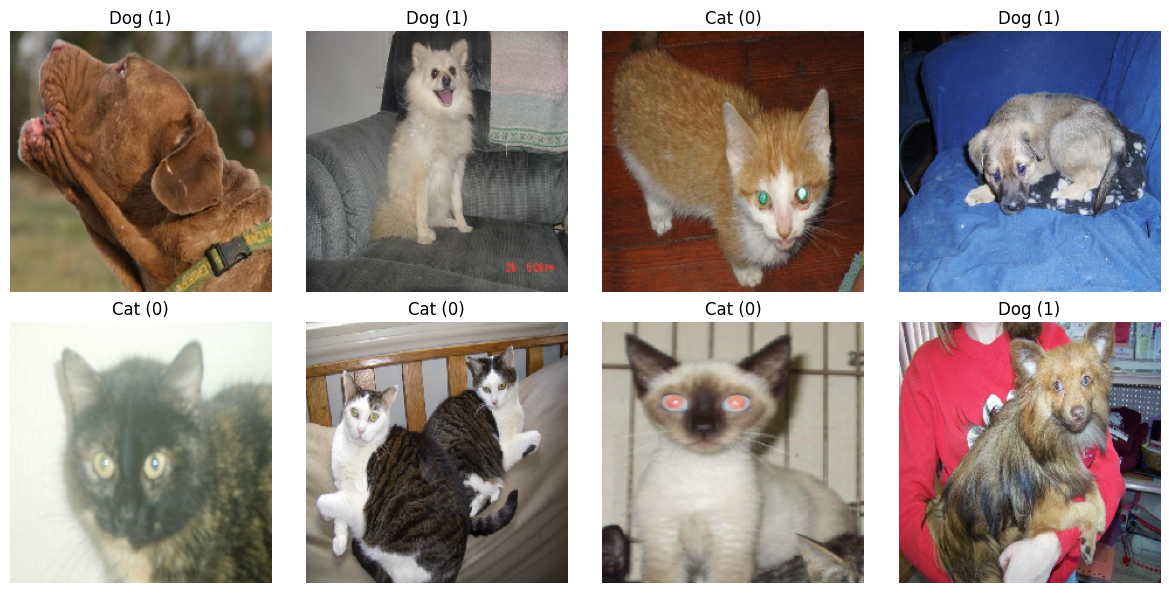

In [11]:
# Setup and Data Loading
print("MSML640 Project: Knowledge Distillation on Cat/Dog Classification with CNN")
print("=" * 50)

# Set device and image size
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_size = 224
print(f"Using device: {device}")
print(f"Image size: {image_size}x{image_size}")

# Load and prepare data
train_images, train_labels, test_images, test_labels = load_and_prepare_data(image_size=image_size)

# Create data loaders
train_loader, test_loader = create_data_loaders(train_images, train_labels, test_images, test_labels)

# Show sample images
print("\nSample training images:")
show_samples(train_loader.dataset)



Creating teacher CNN model...
Teacher CNN Model Architecture:
TeacherCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

Total parameters: 12,939,077
Trainable parameters: 12,939,077

Training teacher CNN model...
Epoch 1/10, Batch 0/313, Loss: 0.6922
Epoch 1/10, Batch 100/313, Loss: 0.6549
Epoch 1/10, Batch 200/313, Loss: 0.6465
Epoch 1/10, Batch 300/313, Loss: 0.5998
Epoch 1/10 - Loss: 0.6783, Train Acc: 60.23%, Test Acc: 65.50%
--------------------------------------------------
Epoch 2/10, Batch 0/313, Loss: 0.5614
Epoch 2/10, Batch

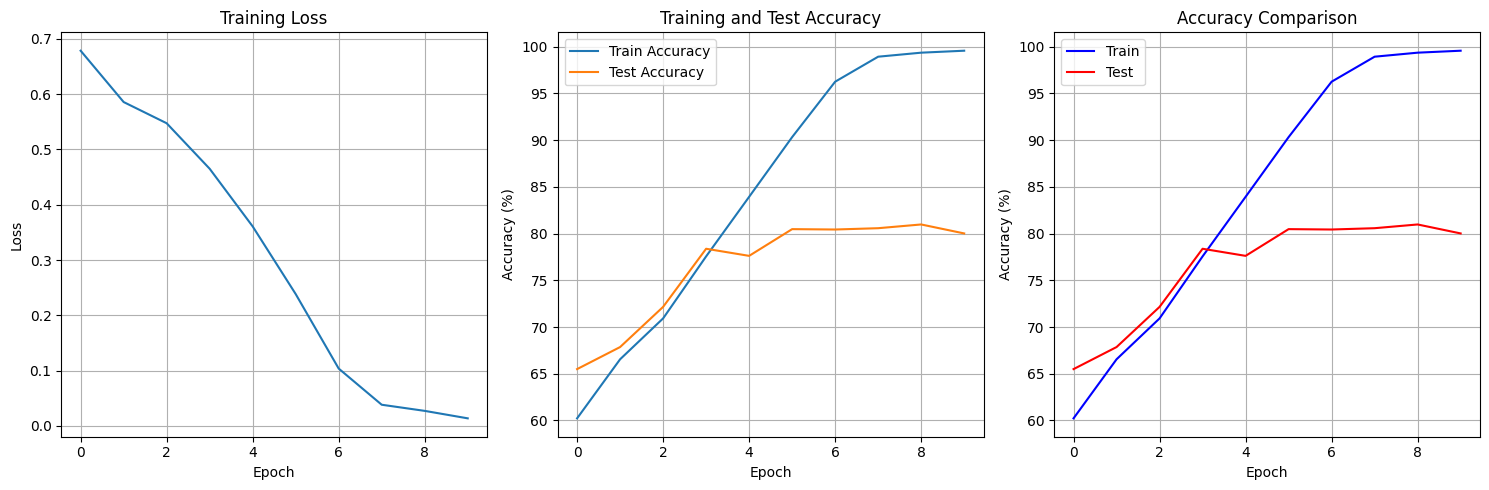

Final Training Accuracy: 99.57%
Final Test Accuracy: 80.02%
Teacher CNN model saved as 'teacher_cnn_model.pth'


In [15]:
# Create and Train Teacher Model
print("\nCreating teacher CNN model...")
teacher_model = TeacherCNN(output_size=5, input_size=image_size).to(device)
print("Teacher CNN Model Architecture:")
print(teacher_model)

# Count parameters
total_params = sum(p.numel() for p in teacher_model.parameters())
trainable_params = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Save initial state
init_state = teacher_model.state_dict()
torch.save(init_state, "init_teacher_cnn.pth")

# Train teacher model
print("\nTraining teacher CNN model...")
train_losses, train_accuracies, test_accuracies = train_teacher_model(
    teacher_model, train_loader, test_loader, device, num_epochs=10
)

# Plot training results
plot_training_results(train_losses, train_accuracies, test_accuracies)

# Save trained teacher model
torch.save(teacher_model.state_dict(), 'teacher_cnn_model.pth')
print("Teacher CNN model saved as 'teacher_cnn_model.pth'")



Testing sample predictions:


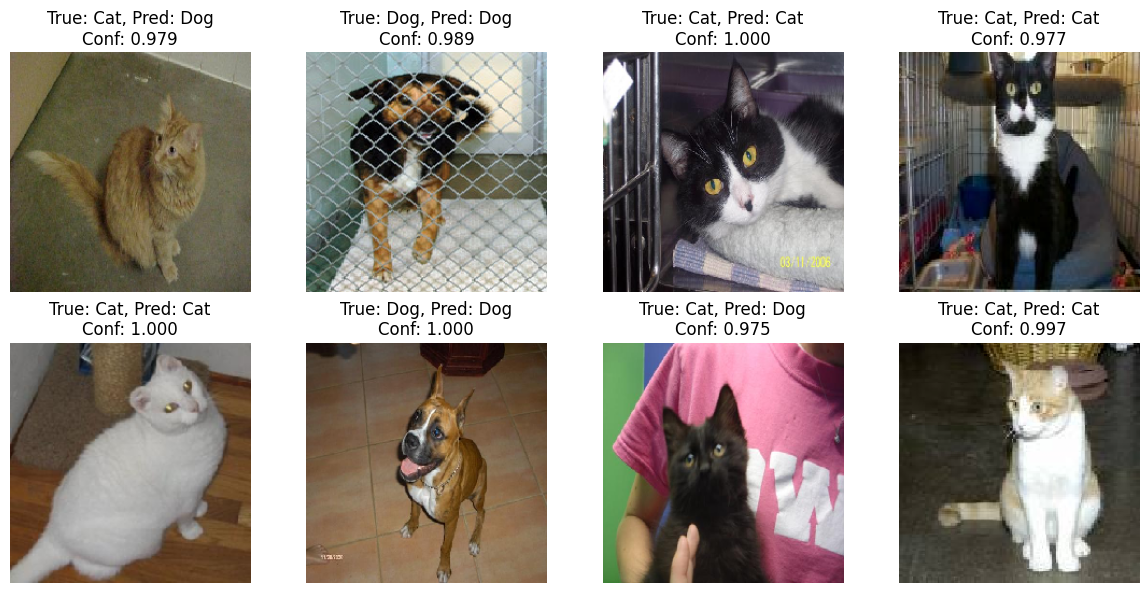

Detailed Logits Analysis:

Sample 1:
True Class: 0 (Cat)
Predicted Class: 1 (Dog)
Confidence: 0.9789
Correct: ✗

All 5 Logits:
First 2 logits (trained): [-1.5907121  2.2483182]
Last 3 logits (untrained): [-0.21131216 -0.3723669   0.08513456]

Softmax probabilities (first 2):
  Cat (0): 0.0211
  Dog (1): 0.9789 ←

Softmax probabilities (last 3):
  Extra 0: 0.3129
  Extra 1: 0.2663
  Extra 2: 0.4208
--------------------------------------------------------------------------------

Sample 2:
True Class: 1 (Dog)
Predicted Class: 1 (Dog)
Confidence: 0.9890
Correct: ✓

All 5 Logits:
First 2 logits (trained): [1.3854661 5.8824935]
Last 3 logits (untrained): [-0.9172374 -2.990506   1.7437855]

Softmax probabilities (first 2):
  Cat (0): 0.0110
  Dog (1): 0.9890 ←

Softmax probabilities (last 3):
  Extra 0: 0.0648
  Extra 1: 0.0081
  Extra 2: 0.9271
--------------------------------------------------------------------------------

Sample 3:
True Class: 0 (Cat)
Predicted Class: 0 (Cat)
Confidence:

In [16]:
# Test Teacher Model Predictions
print("\nTesting sample predictions:")
test_sample_predictions(teacher_model, test_loader, device)

# Detailed logits analysis
print_prediction_logits(teacher_model, test_loader, device, num_samples=5)



Creating student CNN model...
Training student model using knowledge distillation...


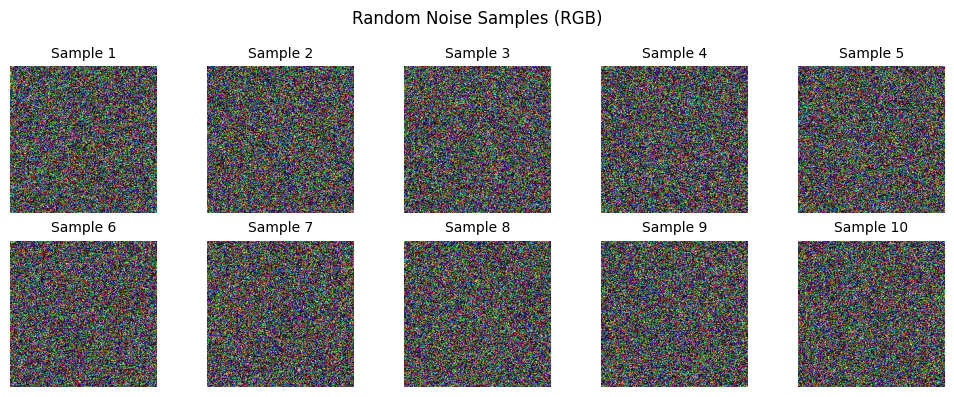

Epoch 1
Epoch 1 Batch 50: batch MSE loss = 0.2940
Epoch 1 Batch 100: batch MSE loss = 0.1483
Epoch 1 Batch 150: batch MSE loss = 0.1135
Epoch 1 Batch 200: batch MSE loss = 0.0905
Epoch 1 Batch 250: batch MSE loss = 0.0914
Epoch 1 Batch 300: batch MSE loss = 0.0958
Epoch 1 Batch 350: batch MSE loss = 0.0766
Epoch 1 Batch 400: batch MSE loss = 0.0799
Epoch 1 Batch 450: batch MSE loss = 0.0774
Epoch 1 Batch 500: batch MSE loss = 0.0672
Epoch 1 Batch 550: batch MSE loss = 0.0684
Epoch 1 Batch 600: batch MSE loss = 0.0848
Epoch 1 Batch 650: batch MSE loss = 0.0777
Epoch 1 Batch 700: batch MSE loss = 0.0705
Epoch 1 Batch 750: batch MSE loss = 0.0903
Epoch 1 Batch 800: batch MSE loss = 0.0756
Epoch 1 Batch 850: batch MSE loss = 0.1015
Epoch 1 Batch 900: batch MSE loss = 0.0789
Epoch 1 Batch 950: batch MSE loss = 0.0861
Epoch 1 Batch 1000: batch MSE loss = 0.0823
Epoch 1 Batch 1050: batch MSE loss = 0.0915
Epoch 1 Batch 1100: batch MSE loss = 0.0670
Epoch 1 Batch 1150: batch MSE loss = 0.0853


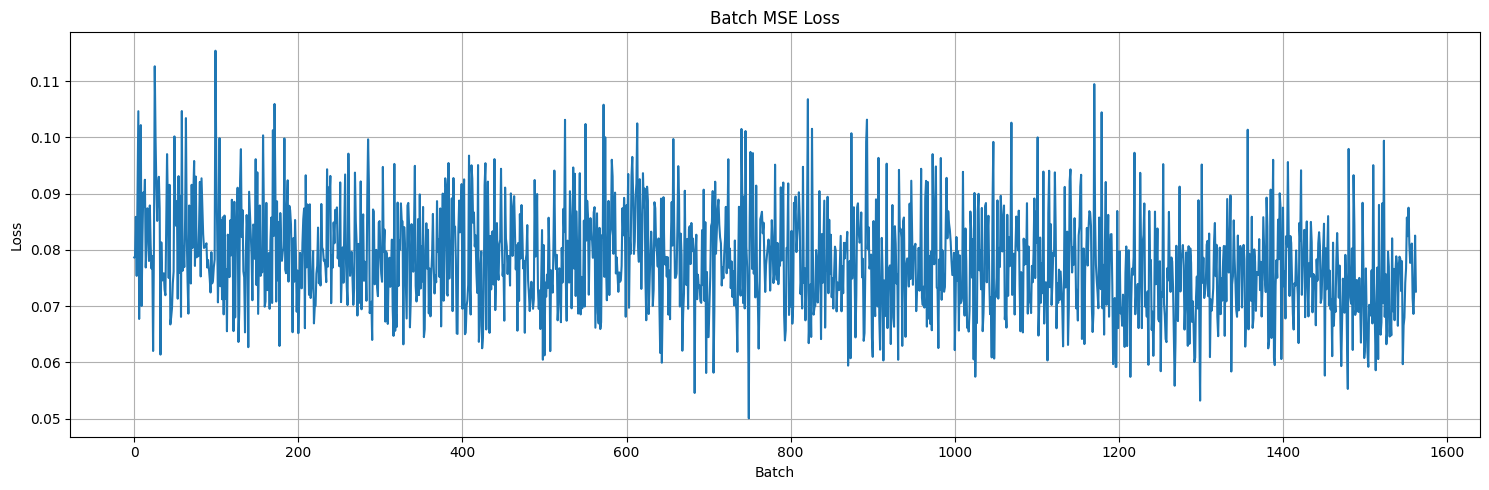

Final Batch MSE Loss: 0.07
Final Average MSE Loss: 0.08

Evaluating student CNN model:
[Student CNN] Batch 50: batch acc = 0.4375, cumulative acc = 0.4888

[Student CNN] Cat/Dog final accuracy = 49.54%


In [17]:
# Create and Train Student Model
print("\nCreating student CNN model...")
student_model = StudentCNN(output_size=5, input_size=image_size).to(device)
student_model.load_state_dict(torch.load("init_teacher_cnn.pth"))

# Load trained teacher model
teacher_model.load_state_dict(torch.load("teacher_cnn_model.pth"))
teacher_model.eval()

# Train student model using knowledge distillation
avg_mse_losses, batch_mse_losses = train_student_model(student_model, teacher_model, device, num_epochs=5, image_size=image_size)

# Plot student training results
plt.figure(figsize=(15, 5))
plt.plot(batch_mse_losses)
plt.title('Batch MSE Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Final Batch MSE Loss: {batch_mse_losses[-1]:.2f}")
print(f"Final Average MSE Loss: {avg_mse_losses[-1]:.2f}")

# Evaluate student model
print("\nEvaluating student CNN model:")
student_acc = eval_on_catdog(student_model, test_loader, device, name="Student CNN")



Creating new student CNN model for comparison...
Training student model using knowledge distillation...


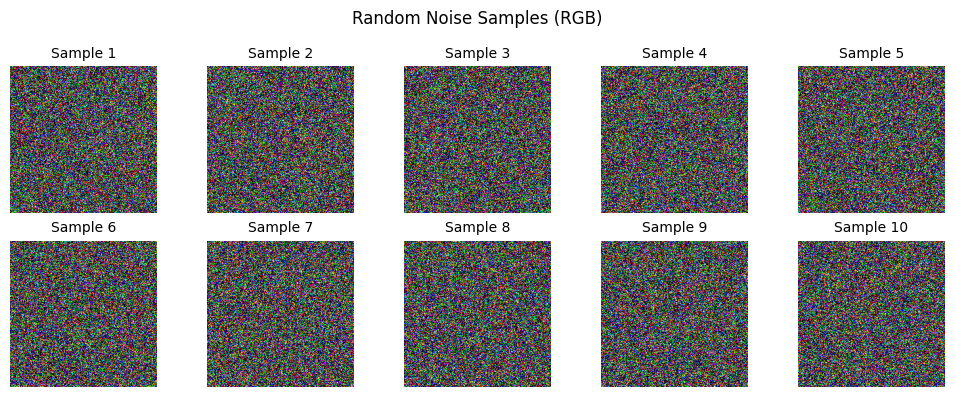

Epoch 1
Epoch 1 Batch 50: batch MSE loss = 0.0920
Epoch 1 Batch 100: batch MSE loss = 0.0870
Epoch 1 Batch 150: batch MSE loss = 0.0977
Epoch 1 Batch 200: batch MSE loss = 0.0964
Epoch 1 Batch 250: batch MSE loss = 0.0583
Epoch 1 Batch 300: batch MSE loss = 0.0703
Epoch 1 Batch 350: batch MSE loss = 0.0809
Epoch 1 Batch 400: batch MSE loss = 0.0890
Epoch 1 Batch 450: batch MSE loss = 0.0899
Epoch 1 Batch 500: batch MSE loss = 0.0938
Epoch 1 Batch 550: batch MSE loss = 0.0781
Epoch 1 Batch 600: batch MSE loss = 0.0814
Epoch 1 Batch 650: batch MSE loss = 0.0789
Epoch 1 Batch 700: batch MSE loss = 0.0825
Epoch 1 Batch 750: batch MSE loss = 0.0644
Epoch 1 Batch 800: batch MSE loss = 0.0748
Epoch 1 Batch 850: batch MSE loss = 0.0825
Epoch 1 Batch 900: batch MSE loss = 0.0746
Epoch 1 Batch 950: batch MSE loss = 0.0855
Epoch 1 Batch 1000: batch MSE loss = 0.0764
Epoch 1 Batch 1050: batch MSE loss = 0.0692
Epoch 1 Batch 1100: batch MSE loss = 0.0653
Epoch 1 Batch 1150: batch MSE loss = 0.0823


In [18]:
10# Create and Train New Student Model for Comparison
print("\nCreating new student CNN model for comparison...")
new_student_model = StudentCNN(output_size=5, input_size=image_size).to(device)

# Train new student model
avg_mse_losses_new, batch_mse_losses_new = train_student_model(new_student_model, teacher_model, device, num_epochs=10, image_size=image_size)

# Evaluate new student model
print("\nEvaluating new student CNN model:")
new_student_acc = eval_on_catdog(new_student_model, test_loader, device, name="New Student CNN")

# Final comparison
print("\n" + "="*50)
print("FINAL RESULTS COMPARISON (Cat/Dog CNN)")
print("="*50)
print(f"Teacher CNN Model Accuracy: {test_accuracies[-1]:.2f}%")
print(f"Student CNN Model Accuracy: {student_acc * 100:.2f}%")
print(f"New Student CNN Model Accuracy: {new_student_acc * 100:.2f}%")
print("="*50)
